<a href="https://colab.research.google.com/github/jhemmer13/DAY2/blob/main/Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Seoul Bike Data Analysis</h1></center>
<br>
Emma Hsu, John Hemmer, Kessupa (Gracie) Phopiboonsuk, and Jacqueline Chen

Package Import

In [ ]:
pip install wget

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn import tree
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_text
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn import preprocessing


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


Get Seoul Bike Data

In [ ]:
import zipfile
# Define the file names
zip_file_name = 'seoul+bike+sharing+demand.zip'
csv_file_name = 'SeoulBikeData.csv'
# Download the file
import wget
wget.download('https://archive.ics.uci.edu/static/public/560/seoul+bike+sharing+demand.zip', zip_file_name)
# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
  zip_ref.extractall()
df = pd.read_csv('SeoulBikeData.csv', encoding='unicode_escape')

df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
df["Month"]=df['Date'].dt.month_name().str[:3]
df["Year"]=df['Date'].dt.year
df["Weekday"] = df['Date'].dt.weekday
df['Weekday']=df['Weekday'].map({0: "Monday",1: "Tuesday",2: "Wednesday" ,3: "Thursday",4:"Friday",5:"Saturday",6:"Sunday"})
df["Weekday"] = pd.Categorical(df["Weekday"], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered = True)

# rename columns
df.rename({"Rented Bike Count":"Bike count", "Temperature(°C)":"Temp","Humidity(%)":"Humidity","Wind speed (m/s)":"Windspeed","Dew point temperature(°C)":"Dew point temp",
           "Solar Radiation (MJ/m2)":"Solar Radiation", "Rainfall(mm)":"Rainfall","Snowfall (cm)":"Snowfall",
           "Visibility (10m)":"Visibility"},axis=1,inplace=True)
# data cleaning
# remove column for "Functioning Day"—we have no need for it
df.drop(columns=['Functioning Day'], inplace=True)
# remove bike count values of 0
df = df[df['Bike count'] != 0]
df

,Date,Bike count,Hour,Temp,Humidity,Windspeed,Visibility,Dew point temp,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Month,Year,Weekday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Dec,2017,Friday
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Dec,2017,Friday
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Dec,2017,Friday
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Dec,2017,Friday
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Dec,2017,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Nov,2018,Friday
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Nov,2018,Friday
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Nov,2018,Friday
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Nov,2018,Friday


# Exploratory Analysis

Exploring the characteristics of the columns

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             8465 non-null   datetime64[ns]
 1   Bike count       8465 non-null   int64         
 2   Hour             8465 non-null   int64         
 3   Temp             8465 non-null   float64       
 4   Humidity         8465 non-null   int64         
 5   Windspeed        8465 non-null   float64       
 6   Visibility       8465 non-null   int64         
 7   Dew point temp   8465 non-null   float64       
 8   Solar Radiation  8465 non-null   float64       
 9   Rainfall         8465 non-null   float64       
 10  Snowfall         8465 non-null   float64       
 11  Seasons          8465 non-null   object        
 12  Holiday          8465 non-null   object        
 13  Month            8465 non-null   object        
 14  Year             8465 non-null   int64  

,Bike count,Hour,Temp,Humidity,Windspeed,Visibility,Dew point temp,Solar Radiation,Rainfall,Snowfall,Year
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.00000,8465.000000,8465.000000
mean,729.156999,11.507029,12.771057,58.147194,1.725883,1433.873479,3.944997,0.567868,0.14912,0.077685,2017.912109
std,642.351166,6.920899,12.104375,20.484839,1.034281,609.051229,13.242399,0.868245,1.12554,0.444063,0.283154
min,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.00000,0.000000,2017.000000
25%,214.000000,6.000000,3.000000,42.000000,0.900000,935.000000,-5.100000,0.000000,0.00000,0.000000,2018.000000
50%,542.000000,12.000000,13.500000,57.000000,1.500000,1690.000000,4.700000,0.010000,0.00000,0.000000,2018.000000
75%,1084.000000,18.000000,22.700000,74.000000,2.300000,2000.000000,15.200000,0.930000,0.00000,0.000000,2018.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.00000,8.800000,2018.000000


Checking if there are any missing values

In [ ]:
df.isna().count()

Date               8465
Bike count         8465
Hour               8465
Temp               8465
Humidity           8465
Windspeed          8465
Visibility         8465
Dew point temp     8465
Solar Radiation    8465
Rainfall           8465
Snowfall           8465
Seasons            8465
Holiday            8465
Month              8465
Year               8465
Weekday            8465
dtype: int64

It looks like there are no missing values in this dataset.

Let's explore the date range of our data

In [ ]:
print("Our dataset starts at " + str(df.Date.min()) + " and \nends at " + str(df.Date.max()))

Our dataset starts at 2017-12-01 00:00:00 and 
ends at 2018-11-30 00:00:00


It looks like this dataset has one complete year's worth of data from 12/1/2017 to 11/30/2018.

Let's see if the datapoints are uniformly distributed for the entire year.

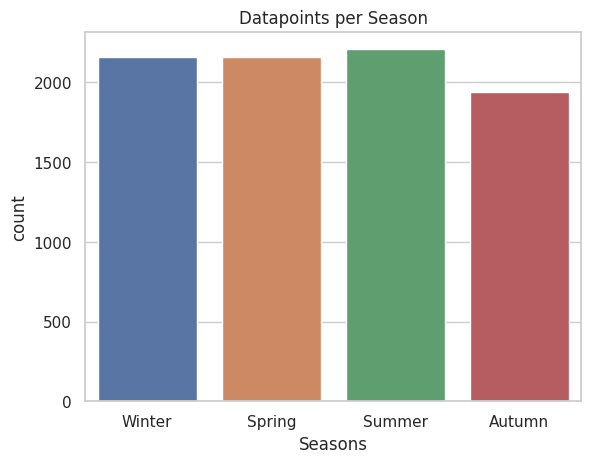

In [ ]:
sns.countplot(x = df['Seasons'])
plt.title('Datapoints per Season')
plt.show()

Yes, there are generally the same amount of datapoints for each season (24 per day, 365 days in total)

There are 744 datapoints from 2017 (2017-12-01 to 2017-12-31) and 7721 datapoints from 2018 (2018-01-01 to 2018-11-30)


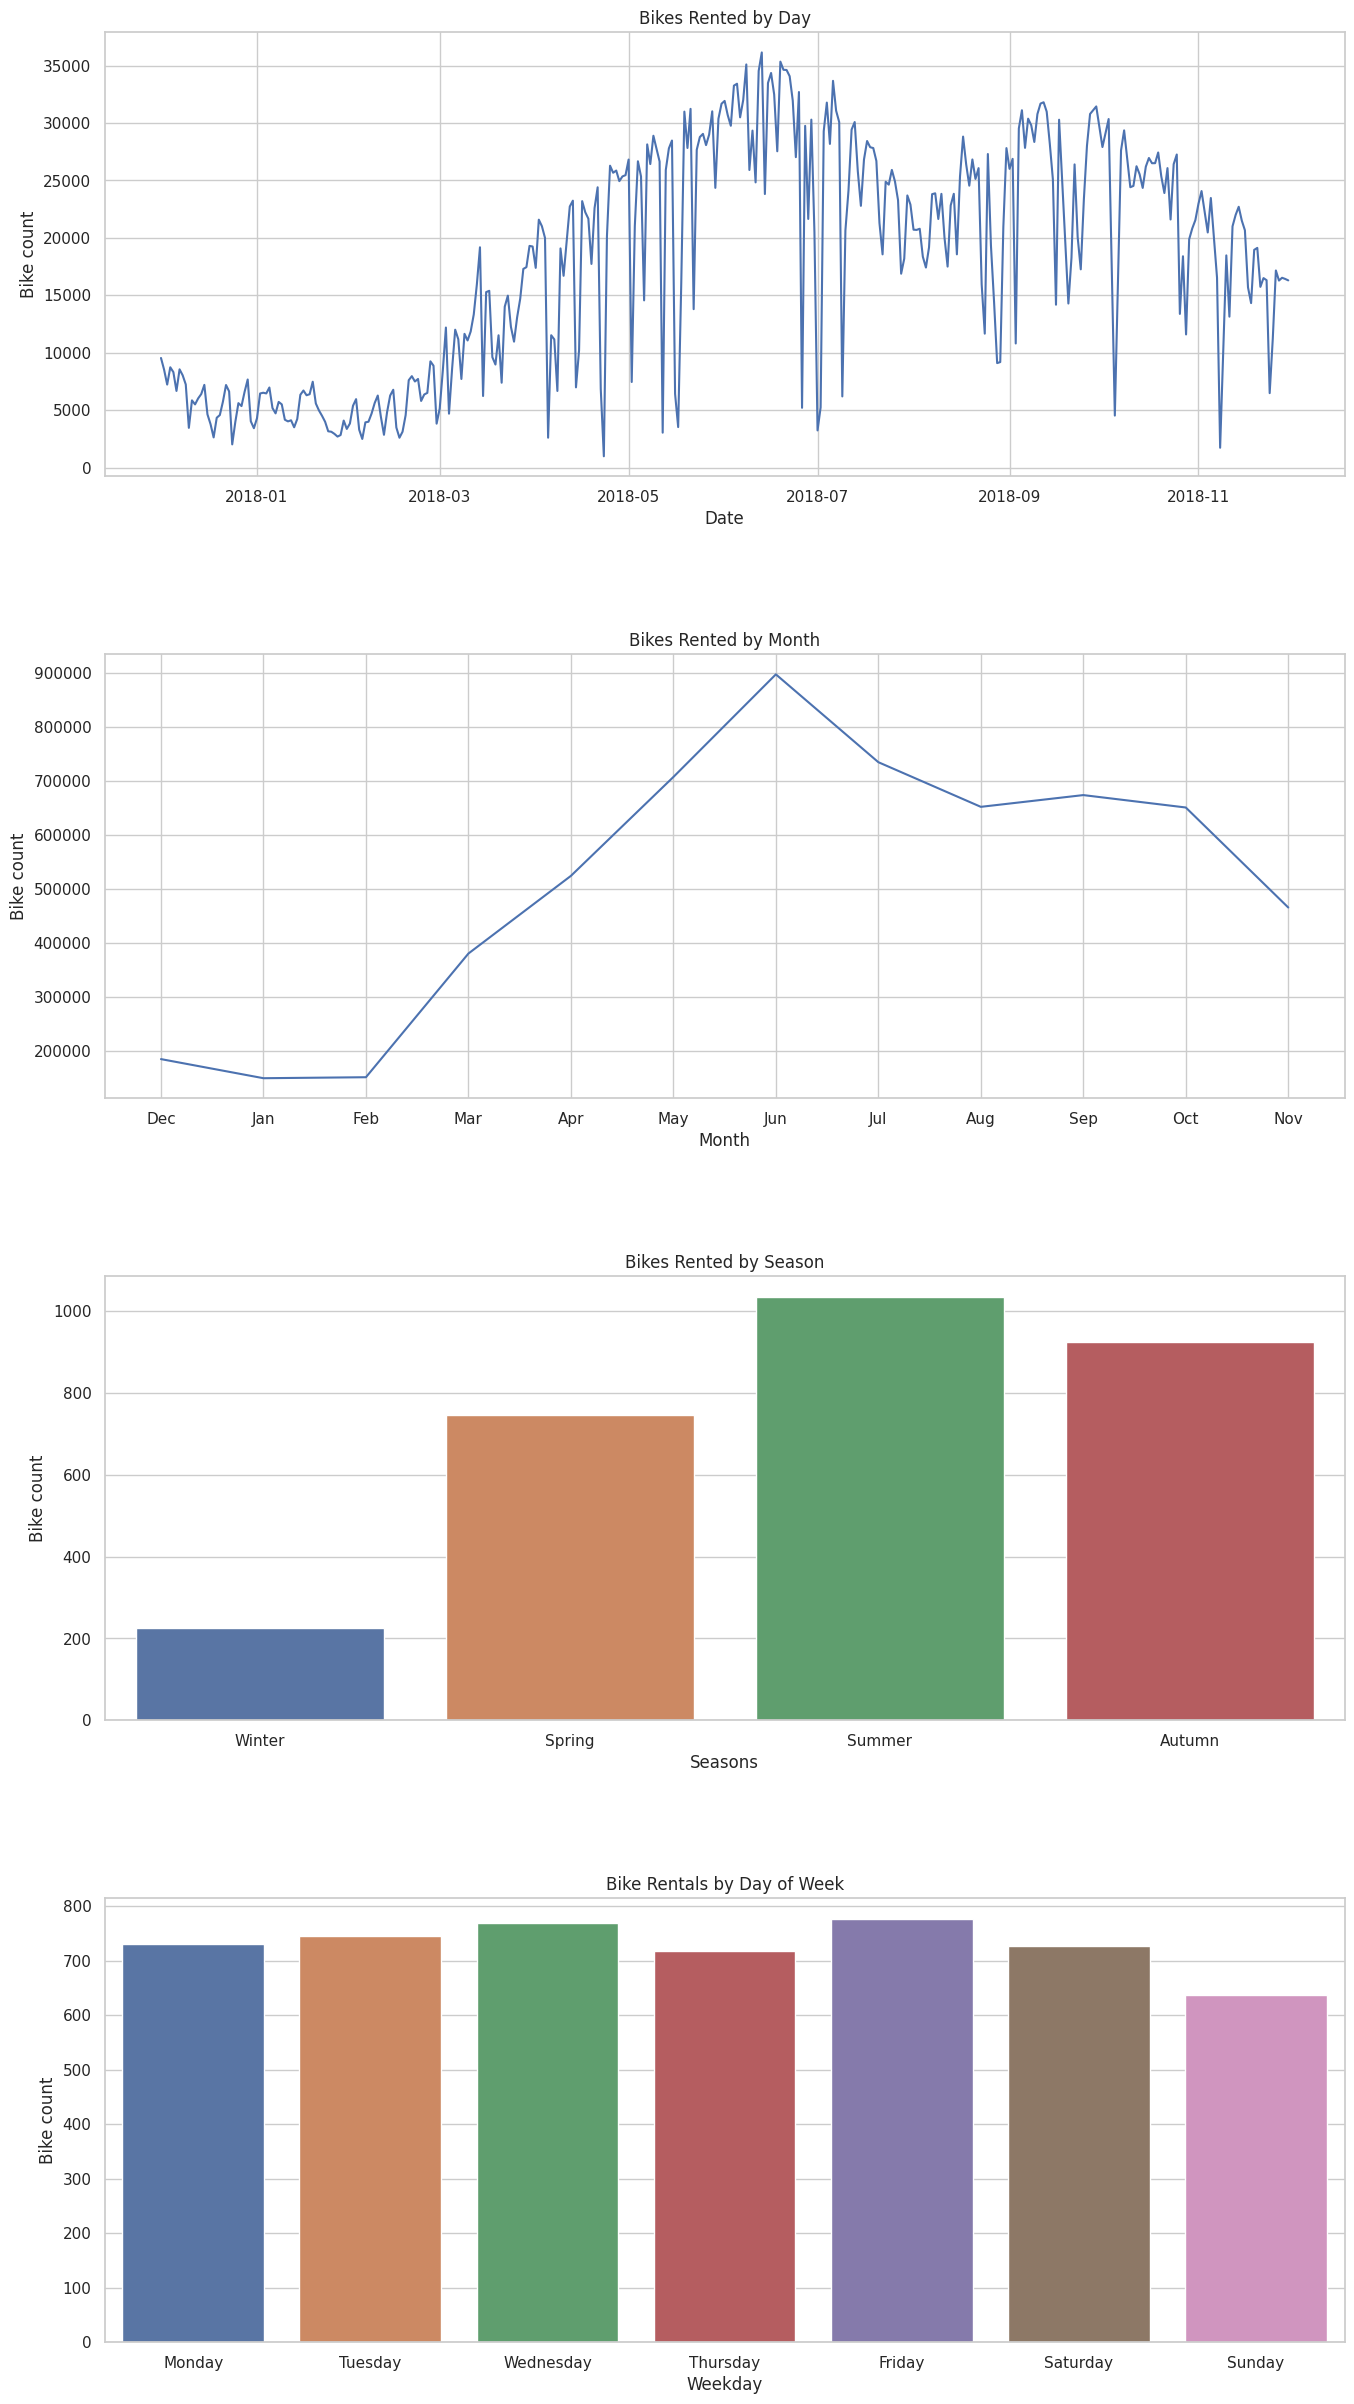

In [ ]:
print(f"There are {len(df[(df['Date'].dt.year == 2017)])} datapoints from 2017 (2017-12-01 to 2017-12-31) and {len(df[(df['Date'].dt.year == 2018)])} datapoints from 2018 (2018-01-01 to 2018-11-30)")
fig,((ax2, ax3, ax4, ax5)) = plt.subplots(4,1,figsize=(16,30), gridspec_kw={'hspace': .4})

# df.plot(x="Date", y="Bike count", ylabel="Bike Rental Count", legend=False, ax=ax1, title="Bike Rentals by Hour")
# sns.lineplot(data=df,x=df.index, y='Bike count', errorbar=None, ax=ax1)

sns.lineplot(data=df.groupby('Date')['Bike count'].sum(), errorbar=None, ax=ax2)
ax2.set_title("Bikes Rented by Day")

monthly_sum = df.groupby('Month')['Bike count'].sum()
monthly_sum = monthly_sum.reindex(['Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
sns.lineplot(data=monthly_sum, errorbar=None, ax=ax3)
ax3.set_title("Bikes Rented by Month")

sns.barplot(data=df, x='Seasons', y='Bike count', errorbar=None, ax=ax4)
ax4.set_title("Bikes Rented by Season")

sns.barplot(data=df, x='Weekday', y='Bike count', errorbar=None, ax=ax5, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax5.set_title("Bike Rentals by Day of Week")

plt.show()

Let's see the peak hours of rental for weekdays versus weekends.

In [ ]:
df['Weekday'].value_counts()

Monday       1248
Friday       1224
Sunday       1224
Saturday     1217
Wednesday    1200
Thursday     1200
Tuesday      1152
Name: Weekday, dtype: int64

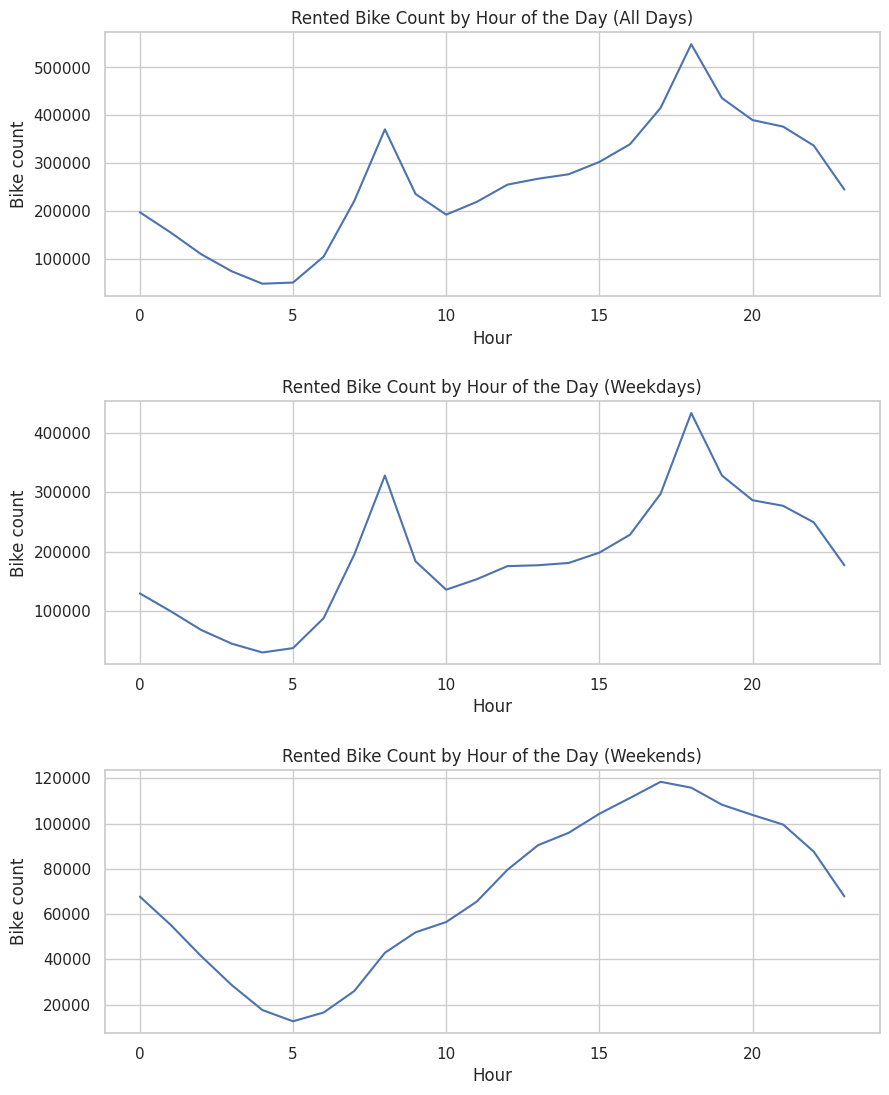

In [ ]:
fig,((ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(10,13), gridspec_kw={'hspace': .4})

sns.lineplot(data=df.groupby('Hour')['Bike count'].sum(), errorbar=None, ax=ax1)
ax1.set_title("Rented Bike Count by Hour of the Day (All Days)")

days_to_filter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_temp = df[df['Weekday'].isin(days_to_filter)]
total_sum_by_hour = df_temp.groupby('Hour')['Bike count'].sum()
sns.lineplot(data=total_sum_by_hour, errorbar=None, ax=ax2)
ax2.set_title("Rented Bike Count by Hour of the Day (Weekdays)")

days_to_filter = ['Saturday', 'Sunday']
df_temp = df[df['Weekday'].isin(days_to_filter)]
total_sum_by_hour = df_temp.groupby('Hour')['Bike count'].sum()
sns.lineplot(data=total_sum_by_hour, errorbar=None, ax=ax3)
ax3.set_title("Rented Bike Count by Hour of the Day (Weekends)")

# for hour 0:
# total_sum = 197633
# weekend_sum = 67725
# weekday_sum = 129908

plt.show()

In [ ]:
# holiday AND weekend
weekend_holiday = df[(df['Holiday'] == 'Holiday') & (df['Weekday'].isin(['Saturday', 'Sunday']))]
print(f'There are {int(weekend_holiday.shape[0]/24)} days in the dataset that is a holiday on a weekend.')

There are 4 days in the dataset that is a holiday on a weekend.


In [ ]:
# holiday AND weekday
weekday_holiday = df[(df['Holiday'] == 'Holiday') & ~(df['Weekday'].isin(['Saturday', 'Sunday']))]
print(f'There are {int(weekday_holiday.shape[0]/24)} days in the dataset that is a holiday on a weekday.')

There are 13 days in the dataset that is a holiday on a weekday.


Let's see if having a holiday on a weekday or weekend affect bike rental volume.

In [ ]:
print(df[df['Holiday'] == 'Holiday'].shape)

(408, 16)


Text(0.5, 1.0, 'Rented Bike Count by Hour of the Day (Holidays on Weekdays)')

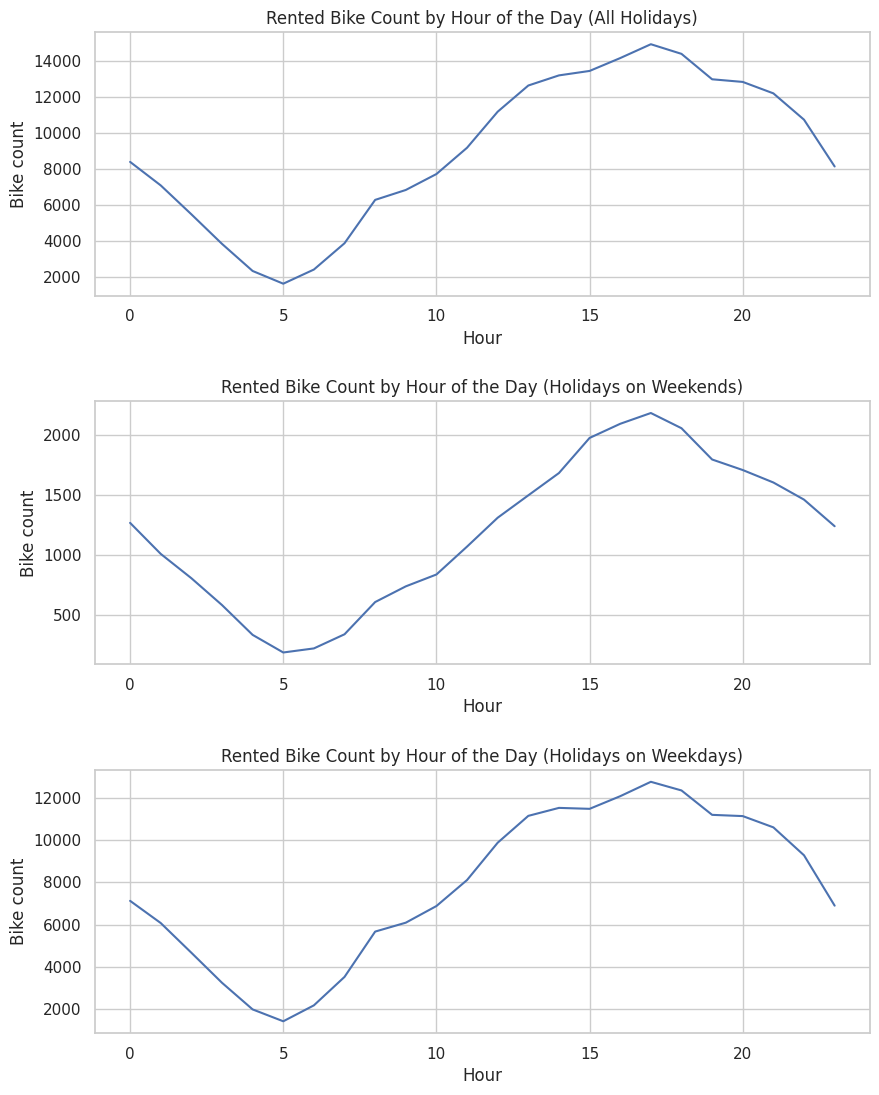

In [ ]:
fig,((ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(10,13), gridspec_kw={'hspace': .4})

# all holidays
sns.lineplot(data=df[df['Holiday'] == 'Holiday'].groupby('Hour')['Bike count'].sum(), errorbar=None, ax=ax1)
ax1.set_title("Rented Bike Count by Hour of the Day (All Holidays)")

# holidays on weekends
sns.lineplot(data=weekend_holiday.groupby('Hour')['Bike count'].sum(), errorbar=None, ax=ax2)
ax2.set_title("Rented Bike Count by Hour of the Day (Holidays on Weekends)")

# holidays on weekdays
sns.lineplot(data=weekday_holiday.groupby('Hour')['Bike count'].sum(), errorbar=None, ax=ax3)
ax3.set_title("Rented Bike Count by Hour of the Day (Holidays on Weekdays)")

This following graph shows the average temperature per month. The blue margins around the line indicate what is within 1 SD from the mean and the yellow margins indicate the top 10% and bottom 10% extreme temperature. These values, especially the extreme temperature cutoffs can be helpful for us to determine "good or bad" weather.

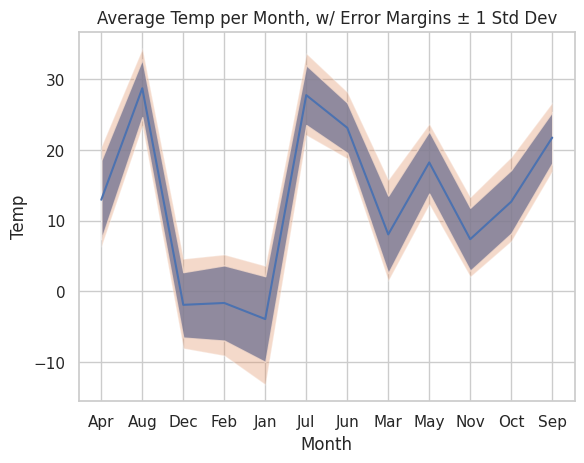

In [ ]:
average_temp = df.groupby('Month')['Temp'].mean()
std_temp = df.groupby('Month')['Temp'].std()
quant_10 = df.groupby('Month')['Temp'].quantile(.1)
quant_90 = df.groupby('Month')['Temp'].quantile(.9)

sns.lineplot(x=average_temp.index, y=average_temp)
plt.fill_between(average_temp.index, average_temp - std_temp, average_temp + std_temp, alpha=0.8)
plt.fill_between(average_temp.index, quant_10, quant_90, alpha=0.3)
plt.title("Average Temp per Month, w/ Error Margins ± 1 Std Dev")
plt.show()

The following series of graphs show the mean and spread of various metrics in our df. They include:

'Temp', 'Humidity', 'Windspeed', 'Visibility', 'Dew point temp', 'Solar Radiation', 'Rainfall', 'Snowfall'

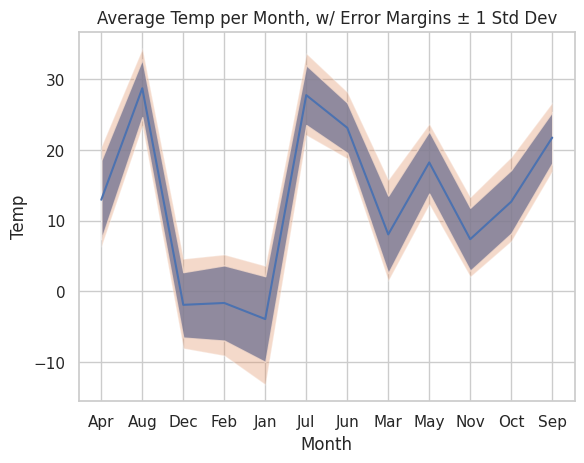

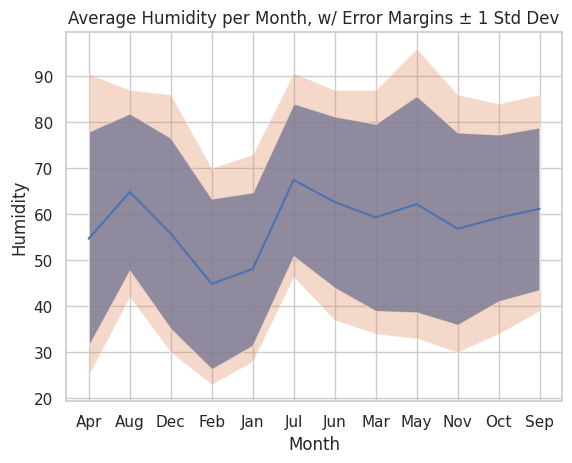

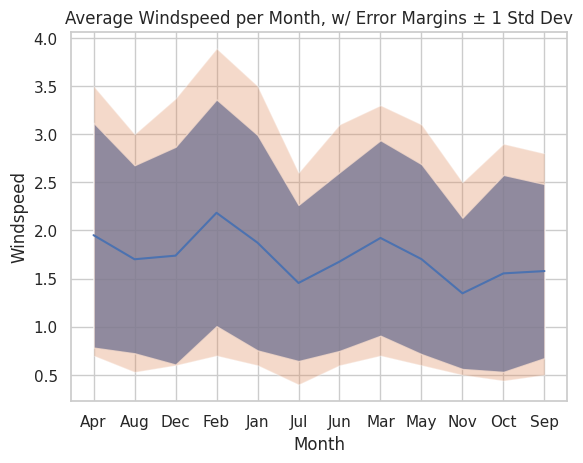

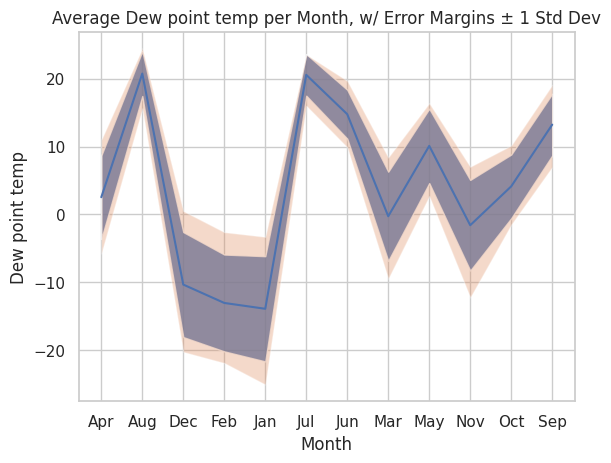

In [ ]:
columns_to_plot = ['Temp', 'Humidity', 'Windspeed', 'Dew point temp']

for column in columns_to_plot:
  average_column = df.groupby('Month')[column].mean()
  std_column = df.groupby('Month')[column].std()
  quant_10 = df.groupby('Month')[column].quantile(.1)
  quant_90 = df.groupby('Month')[column].quantile(.9)

  sns.lineplot(x=average_column.index, y=average_column)

  plt.fill_between(average_column.index, average_column - std_column, average_column + std_column, alpha=0.8)
  plt.fill_between(average_column.index, quant_10, quant_90, alpha=0.3)
  # Set the title for the plot based on the current column
  plt.title(f"Average {column} per Month, w/ Error Margins ± 1 Std Dev")

  # Display the plot for the current column
  plt.show()

## Random Forest Regression

In [ ]:
#Create dummy variables for categorical variables
df1 = pd.get_dummies(df, columns=['Seasons', 'Holiday', 'Month', 'Weekday'], prefix=['Seasons', 'Holiday', 'Month', 'Weekday'])
#Print column names to get dummy variable names
print(df1.columns)
df1.info()

Index(['Date', 'Bike count', 'Hour', 'Temp', 'Humidity', 'Windspeed',
       'Visibility', 'Dew point temp', 'Solar Radiation', 'Rainfall',
       'Snowfall', 'Year', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer', 'Seasons_Winter', 'Holiday_Holiday',
       'Holiday_No Holiday', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Weekday_Monday',
       'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday',
       'Weekday_Friday', 'Weekday_Saturday', 'Weekday_Sunday'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                8465 non-null   datetime64[ns]
 1   Bike count          8465 non-null   int64         
 2   Hour                8465 non-

In [ ]:
train, test = train_test_split(df1, test_size=0.15, random_state=5)
#Separating class, our predictor variable for the y axis. X is everything else, so drop class
#Create training and test y values
train_y = train['Bike count']
train_x = train[['Hour', 'Temp', 'Humidity', 'Windspeed',
       'Visibility', 'Dew point temp', 'Solar Radiation', 'Rainfall',
       'Snowfall', 'Year', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer', 'Seasons_Winter', 'Holiday_Holiday',
       'Holiday_No Holiday', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Weekday_Monday',
       'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday',
       'Weekday_Friday', 'Weekday_Saturday', 'Weekday_Sunday']]
test_y = test['Bike count']
test_x = test[['Hour', 'Temp', 'Humidity', 'Windspeed',
       'Visibility', 'Dew point temp', 'Solar Radiation', 'Rainfall',
       'Snowfall', 'Year', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer', 'Seasons_Winter', 'Holiday_Holiday',
       'Holiday_No Holiday', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Weekday_Monday',
       'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday',
       'Weekday_Friday', 'Weekday_Saturday', 'Weekday_Sunday']]
#View the data
print(train_y.head())
print(train_x.head())

1343     79
2661    231
2340    375
7827    243
3365    168
Name: Bike count, dtype: int64
      Hour  Temp  Humidity  Windspeed  Visibility  Dew point temp  \
1343    23 -14.9        35        2.8        2000           -26.9   
2661    21   1.2        92        0.7        1474             0.0   
2340    12   5.6        72        3.0        1700             0.9   
7827     3  10.1        70        1.1         606             4.8   
3365     5  11.4        60        0.4         851             3.8   

      Solar Radiation  Rainfall  Snowfall  Year  ...  Month_Nov  Month_Oct  \
1343             0.00       0.0       0.5  2018  ...          0          0   
2661             0.00       0.5       0.0  2018  ...          0          0   
2340             0.89       0.0       0.0  2018  ...          0          0   
7827             0.00       0.0       0.0  2018  ...          0          1   
3365             0.00       0.0       0.0  2018  ...          0          0   

      Month_Sep  Weekday_

In [ ]:
#Run a grid search to identify the optimal parameters for the Random Forest Model
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, 150],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)

#Copy code to a different IDE and run it
##Grid search to find the best parameters
#grid_search.fit(train_x, train_y)
##took too long and failed^
##Update: doesn't work on collab, but works on visual studio code
#print(grid_search.best_params_)


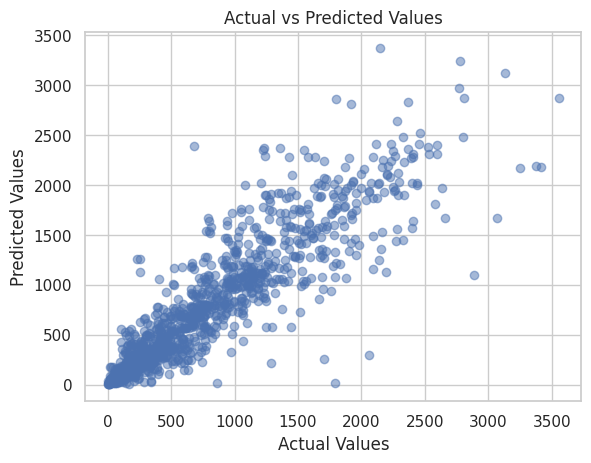

In [ ]:
#Use the identified parameters from the grid search
Parameters = {'bootstrap': True,
 'max_depth': 150,
 'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 200
 }

rf = RandomForestClassifier(**Parameters)
rf.fit(train_x, train_y)
y = rf.predict(test_x)

#Create scatterplot with the test x and the predicted y
plt.scatter(test_y, y, alpha = 0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

Run Evaluation metrics: r squared and mean squared error

In [ ]:
#Print r squared and mean squared error
r_squared = r2_score(test_y, y)
print(r_squared)

mse = mean_squared_error(test_y, y)
print(mse)

0.8097993793273053
81529.24173228347


In [ ]:
feature_importances = rf.feature_importances_

#Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': train_x.columns, 'Importance': feature_importances})

#Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#Print the sorted feature importances
print(feature_importance_df)
print(train_x.columns)

               Feature  Importance
1                 Temp    0.118478
5       Dew point temp    0.116524
2             Humidity    0.111174
3            Windspeed    0.109994
4           Visibility    0.102598
0                 Hour    0.095534
6      Solar Radiation    0.073452
34      Weekday_Sunday    0.019457
31    Weekday_Thursday    0.019449
28      Weekday_Monday    0.019416
32      Weekday_Friday    0.018986
29     Weekday_Tuesday    0.018969
33    Weekday_Saturday    0.018721
30   Weekday_Wednesday    0.018477
7             Rainfall    0.012808
8             Snowfall    0.011552
11      Seasons_Spring    0.007777
16           Month_Apr    0.007726
10      Seasons_Autumn    0.007376
24           Month_May    0.006968
21           Month_Jul    0.006837
23           Month_Mar    0.006769
26           Month_Oct    0.006747
17           Month_Aug    0.006707
22           Month_Jun    0.006702
14     Holiday_Holiday    0.006622
15  Holiday_No Holiday    0.006220
25           Month_N

In [ ]:
#want to print monthly averages of date vs predicted values and date vs actual values
newdf = pd.DataFrame()
newdf['Date'] = test['Date']
newdf['Predicted bike count'] = y
newdf['Date'] = pd.to_datetime(newdf.Date, format='%d/%m/%Y')
newdf["Month"]=newdf['Date'].dt.month_name().str[:3]
newdf["Year"]=newdf['Date'].dt.year
newdf["Weekday"] = df['Date'].dt.weekday
newdf['Weekday']=newdf['Weekday'].map({0: "Monday",1: "Tuesday",2: "Wednesday" ,3: "Thursday",4:"Friday",5:"Saturday",6:"Sunday"})
newdf["Weekday"] = pd.Categorical(newdf["Weekday"], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered = True)
newdf["Month"] = pd.Categorical(newdf["Month"], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered = True)

newdf.head()
monthly_sum = newdf.groupby('Date')['Predicted bike count'].sum()

In [ ]:
testdf = pd.DataFrame()
testdf['Date'] = test['Date']
testdf['Bike Count'] = test['Bike count']
testdf['Date'] = pd.to_datetime(testdf.Date, format='%d/%m/%Y')

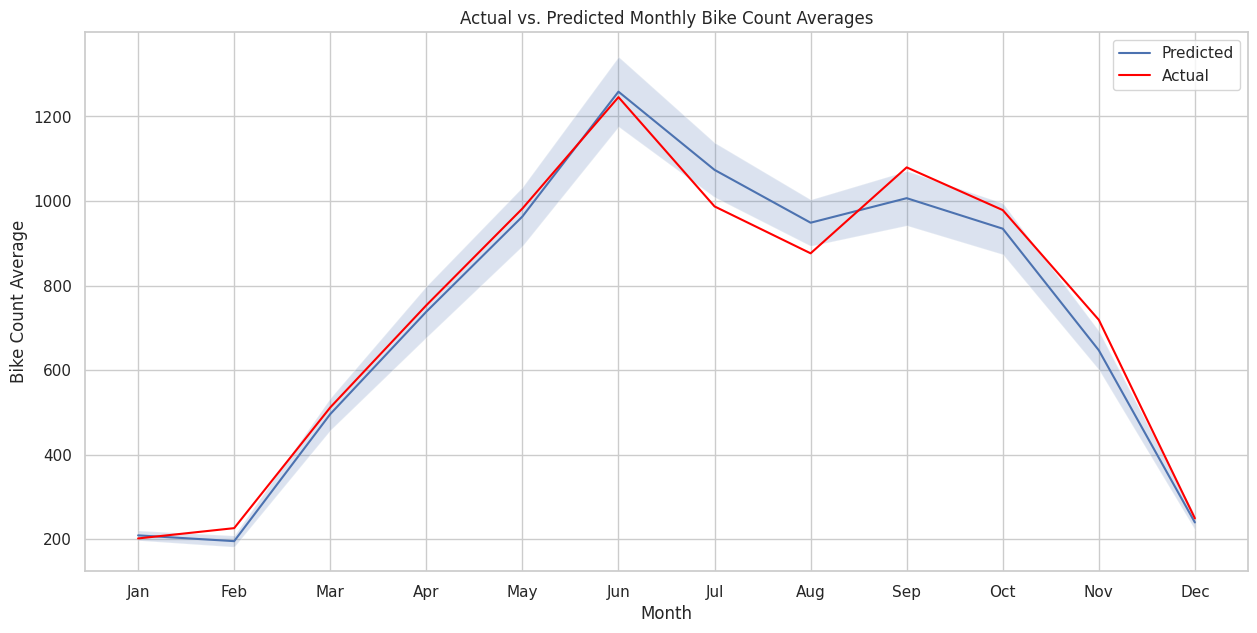

<Figure size 1000x500 with 0 Axes>

In [ ]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1,figsize=(15, 7), gridspec_kw={'hspace': .4})
ax.set_title("Actual vs. Predicted Monthly Bike Count Averages")
grouped_df = newdf.groupby('Month')['Predicted bike count'].agg(['mean', 'sem']).reset_index()

#Plot the line plot with confidence intervals
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='mean', data=grouped_df, label='Predicted', ax=ax)
ax.fill_between(x=grouped_df['Month'], y1=grouped_df['mean'] - grouped_df['sem'], y2=grouped_df['mean'] + grouped_df['sem'], alpha=0.2)
sns.lineplot(data=df.groupby('Month')['Bike count'].mean(), ax = ax, color = 'red', label = 'Actual')
ax.set_xlabel('Month')
ax.set_ylabel('Bike Count Average')
ax.legend()


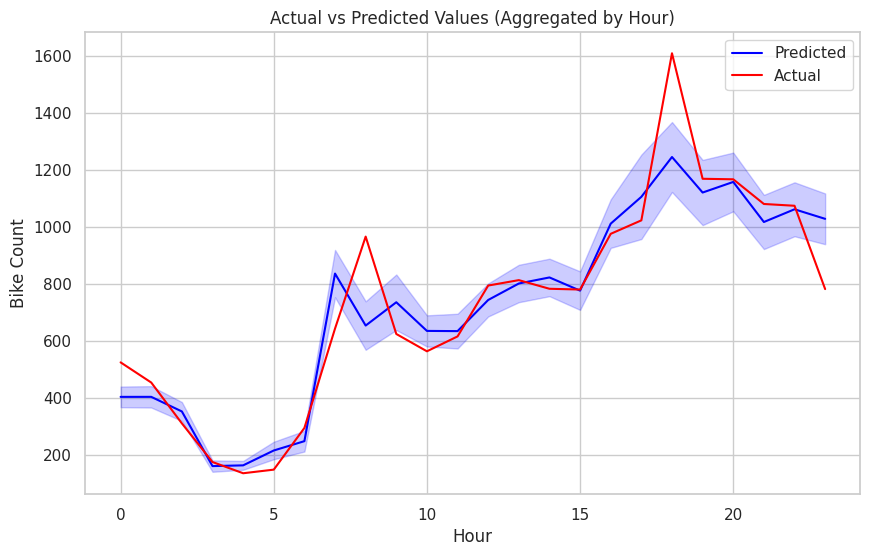

In [ ]:
results_df = pd.DataFrame({'Actual': test_y, 'Predicted': y, 'Hour': test_x['Hour']})

#Aggregate the results by hour
agg_results = results_df.groupby('Hour').mean().reset_index()

#Create a line graph with Seaborn's lineplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(data=agg_results, x='Hour', y='Predicted', color='blue', label='Predicted')
std_err_pred = results_df.groupby('Hour')['Predicted'].sem().reset_index()

#Create an error bar
plt.fill_between(agg_results['Hour'], agg_results['Predicted'] - std_err_pred['Predicted'], agg_results['Predicted'] + std_err_pred['Predicted'], color='blue', alpha=0.2)
sns.lineplot(data=agg_results, x='Hour', y='Actual', color='red', label='Actual')

plt.title('Actual vs Predicted Values (Aggregated by Hour)')
plt.xlabel('Hour')
plt.ylabel('Bike Count')
plt.legend()
plt.show()

Categorical --> continuous

In [ ]:
encoder = preprocessing.LabelEncoder()
# no holiday: 1, holiday: 0
# winter: 3, spring: 1, summer: 2, fall: 0
for col in ['Seasons','Holiday','Month','Weekday']:
  df[col]=encoder.fit_transform(df[col])
display(df)

,Date,Bike count,Hour,Temp,Humidity,Windspeed,Visibility,Dew point temp,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Month,Year,Weekday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,1,2,2017,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,1,2,2017,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,1,2,2017,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,1,2,2017,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,1,2,2017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,0,1,9,2018,0
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,0,1,9,2018,0
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,0,1,9,2018,0
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,0,1,9,2018,0


Multiple Linear Regression

In [ ]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
X = df.iloc[:,2:]
X_cols = X.columns
y = df['Bike count']
X_normalized = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X_cols)
X_scaled = pd.DataFrame(standard_scaler.fit_transform(X_normalized), columns=X_cols)
X_scaled.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
multiple_model = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(multiple_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Bike count   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     738.7
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:42:49   Log-Likelihood:                -63355.
No. Observations:                8465   AIC:                         1.267e+05
Df Residuals:                    8450   BIC:                         1.268e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             729.1570      4.686    1

Correlation matrix

In [ ]:
corr=df.corr()
corr.style.background_gradient(cmap='coolwarm')

<ipython-input-60-a2946110b1c6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=df.corr()


,Bike count,Hour,Temp,Humidity,Windspeed,Visibility,Dew point temp,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Month,Year,Weekday
Bike count,1.000000,0.425256,0.562740,-0.201973,0.125022,0.212323,0.400263,0.273862,-0.128626,-0.151611,-0.313531,0.070070,0.234110,0.232004,-0.000371
Hour,0.425256,1.000000,0.122742,-0.235937,0.287780,0.103869,0.004691,0.144658,0.014345,-0.022082,-0.001420,0.000229,0.001379,0.000315,-0.000491
Temp,0.562740,0.122742,1.000000,0.166425,-0.038481,0.028262,0.914467,0.354844,0.052149,-0.217746,-0.333517,0.057977,0.137871,0.377003,0.000641
Humidity,-0.201973,-0.235937,0.166425,1.000000,-0.337352,-0.548542,0.539402,-0.457273,0.236917,0.110127,-0.120001,0.047796,0.081325,0.035188,0.031230
Windspeed,0.125022,0.287780,-0.038481,-0.337352,1.000000,0.180428,-0.177170,0.326222,-0.024931,-0.003789,0.108327,-0.031432,-0.113032,-0.003568,0.030484
Visibility,0.212323,0.103869,0.028262,-0.548542,0.180428,1.000000,-0.182586,0.153046,-0.170352,-0.122860,-0.006786,-0.022210,0.011745,0.051802,0.039295
Dew point temp,0.400263,0.004691,0.914467,0.539402,-0.177170,-0.182586,1.000000,0.098525,0.126812,-0.149760,-0.326239,0.067625,0.154209,0.334985,0.014561
Solar Radiation,0.273862,0.144658,0.354844,-0.457273,0.326222,0.153046,0.098525,1.000000,-0.074157,-0.073380,-0.080288,0.001963,0.028763,0.130141,-0.016576
Rainfall,-0.128626,0.014345,0.052149,0.236917,-0.024931,-0.170352,0.126812,-0.074157,1.000000,0.008604,-0.020083,0.013301,-0.000830,0.028228,0.017874
Snowfall,-0.151611,-0.022082,-0.217746,0.110127,-0.003789,-0.122860,-0.149760,-0.073380,0.008604,1.000000,0.142224,0.012043,-0.071683,-0.205030,0.047625


XGBoost

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

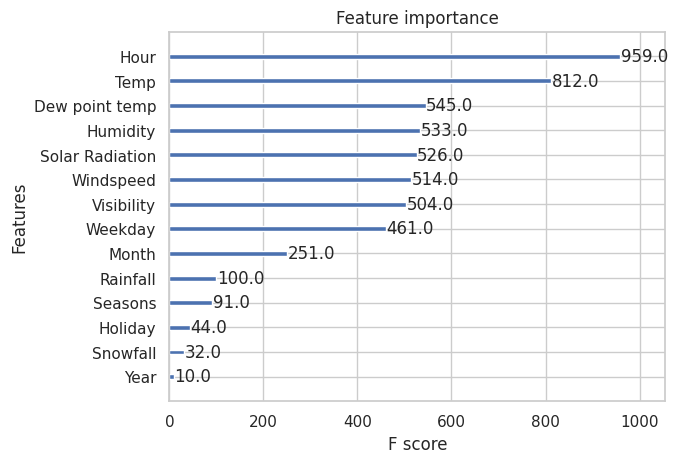

In [ ]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X, y)
xgb.plot_importance(xg_reg)

LassoCV

In [ ]:
lasso_regression=LassoCV(max_iter=1500)
lasso_regression.fit(X,y)
print('chosen coefficients:')
for i in range(0,len(X.columns)):
    if lasso_regression.coef_[i]!=0:
        print(X.columns[i],':',lasso_regression.coef_[i])
# lasso better than ridge because lasso can drive features to 0, but ridge can only get close to zero,
# also helpful in handling redundant features, since some features may have high correlation, only one is needed
# In bike sharing data, it's possible that only a subset of the features have a meaningful impact on bike count.
# Lasso promotes sparsity in the model, meaning it tends to produce models with fewer non-zero coefficients.

chosen coefficients:
Hour : 26.90366147185869
Temp : 26.084054945869102
Humidity : -6.635316720374839
Visibility : 0.06149993557474487
Dew point temp : 2.095332782461193
Month : 26.0315063961159


Decision Tree Classifier

Accuracy: 0.6839929119905493
|--- Temp <= 1.50
|   |--- Hour <= 0.50
|   |   |--- Temp <= 0.50
|   |   |   |--- class: Low
|   |   |--- Temp >  0.50
|   |   |   |--- class: Low
|   |--- Hour >  0.50
|   |   |--- Temp <= 0.50
|   |   |   |--- Hour <= 1.50
|   |   |   |   |--- class: Low
|   |   |   |--- Hour >  1.50
|   |   |   |   |--- Hour <= 2.50
|   |   |   |   |   |--- class: Low
|   |   |   |   |--- Hour >  2.50
|   |   |   |   |   |--- class: Low
|   |   |--- Temp >  0.50
|   |   |   |--- Hour <= 1.50
|   |   |   |   |--- class: Normal
|   |   |   |--- Hour >  1.50
|   |   |   |   |--- Hour <= 2.50
|   |   |   |   |   |--- class: Normal
|   |   |   |   |--- Hour >  2.50
|   |   |   |   |   |--- class: Normal
|--- Temp >  1.50
|   |--- Hour <= 1.50
|   |   |--- Hour <= 0.50
|   |   |   |--- Temp <= 2.50
|   |   |   |   |--- class: Normal
|   |   |   |--- Temp >  2.50
|   |   |   |   |--- class: Normal
|   |   |--- Hour >  0.50
|   |   |   |--- Temp <= 2.50
|   |   |   |   |--- cla

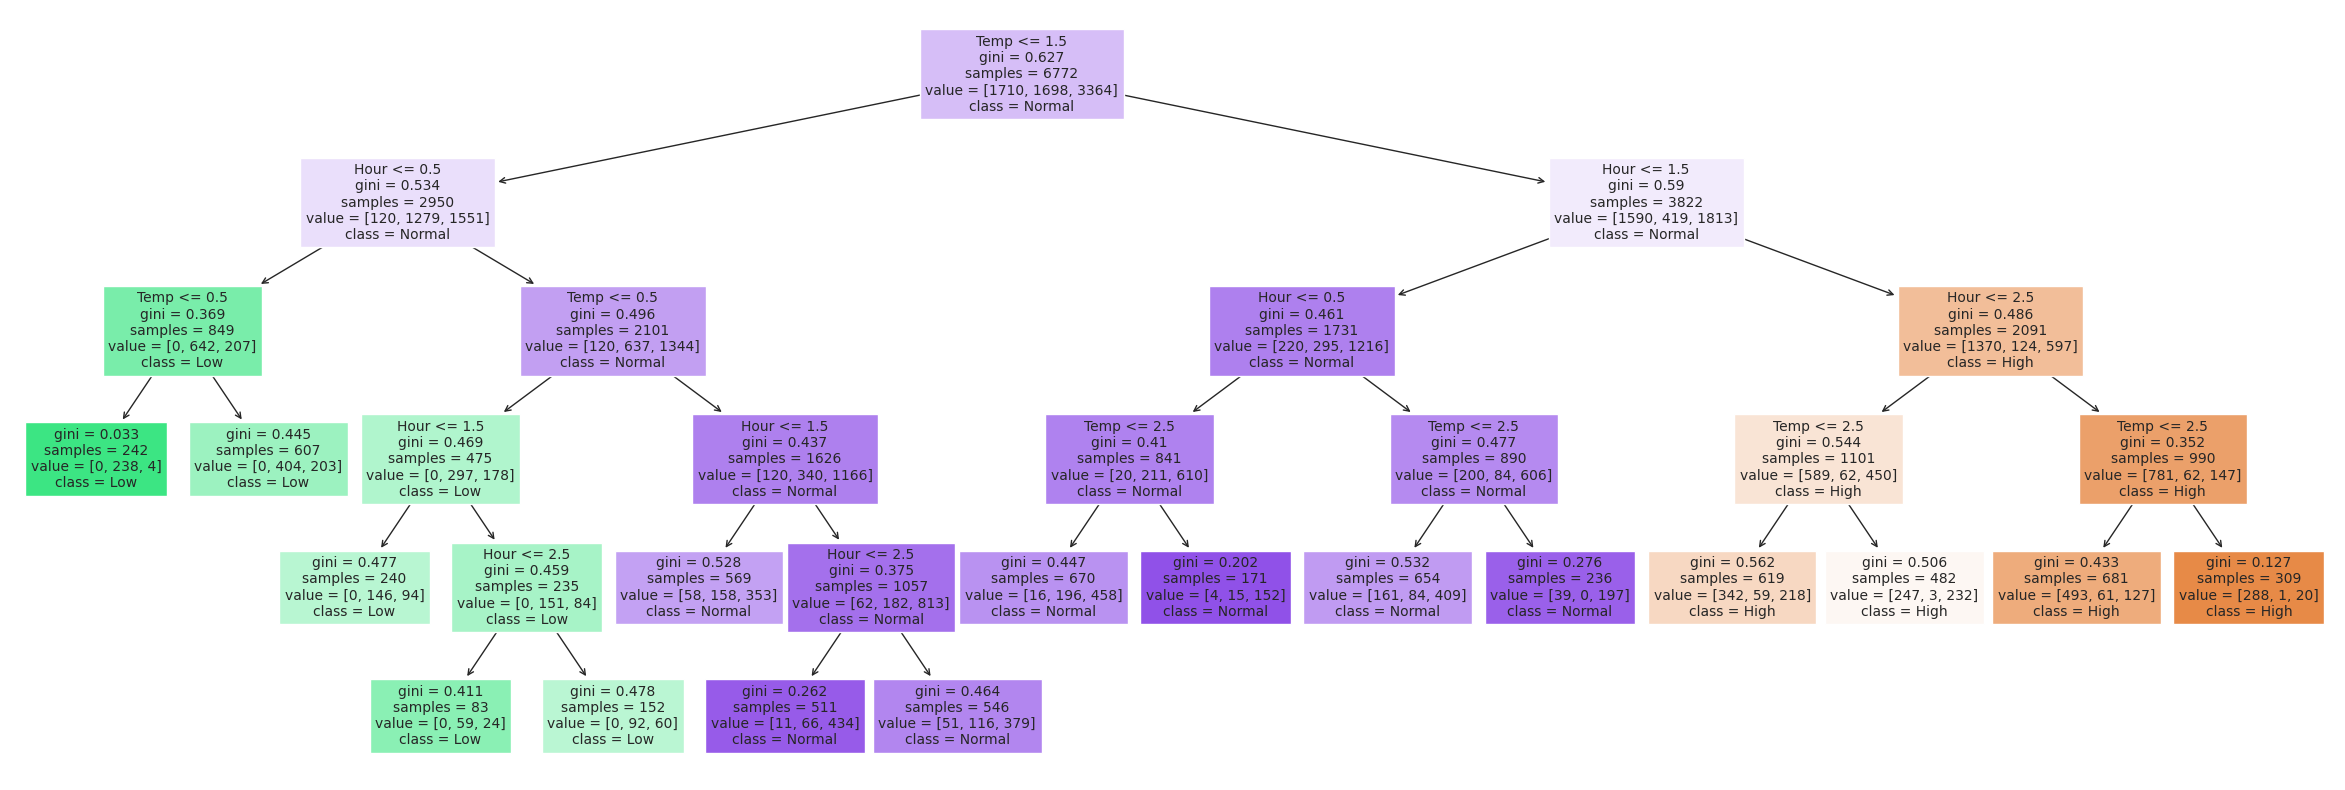

In [ ]:
col= ['Hour', 'Temp']
x_poly=df[col]
y=df['Bike count']
lower_threshold = 214  # Example threshold values, adjust as needed
upper_threshold = 1084

# Create labels for the bins
labels = ['Low', 'Normal', 'High']

# Bin the 'Bike count' variable
y_binned = pd.cut(y, bins=[float('-inf'), lower_threshold, upper_threshold, float('inf')], labels=labels)
n_bins = 4  # Number of bins for each feature
strategy = 'uniform'
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
# Fit and transform the features
X_binned = discretizer.fit_transform(x_poly)
x_train, x_test, y_train, y_test = train_test_split(X_binned, y_binned, test_size=0.2)
classifier = DecisionTreeClassifier(random_state=42)

# Train the model
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
tree_rules = export_text(classifier, feature_names=list(col))
print(tree_rules)
plt.figure(figsize=(30, 10))
plot_tree(classifier, filled=True, feature_names=x_poly.columns, class_names=classifier.classes_, fontsize=10)
plt.show()

##Multinomial Polynomial Regression


Mean Squared Error: 135011.73868780123
R-squared:0.68593749377491


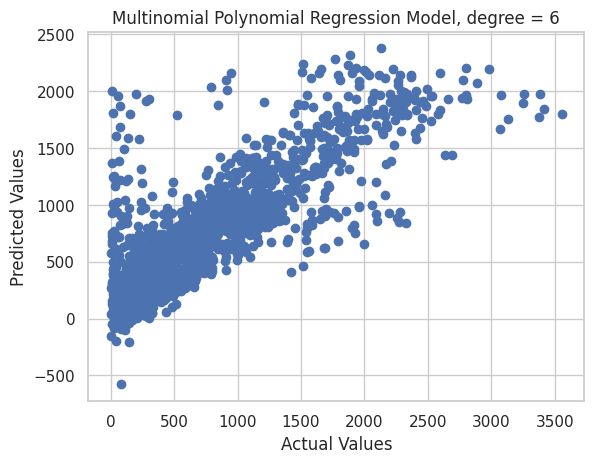

In [ ]:
# one hot encoding weekday and holiday
oh_df=pd.get_dummies(df, columns=['Weekday', 'Holiday'])
# print(oh_df.head())
# extracting the 10 variables of interest (4 features: temp, hour, holiday, weekday)
X1 = oh_df['Temp']
X2 = oh_df['Hour']
X3 = oh_df['Holiday_0']
X4 = oh_df['Weekday_0']
X5 = oh_df['Weekday_1']
X6 = oh_df['Weekday_2']
X7 = oh_df['Weekday_3']
X8 = oh_df['Weekday_4']
X9 = oh_df['Weekday_5']
X10 = oh_df['Weekday_6']
y = oh_df['Bike count']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.column_stack((X1, X2, X3, X4, X5, X6, X7, X8, X9, X10)), y, test_size=0.2, random_state=5)

# create the polynomial features
degree = 6
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# train a linear regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# make predictions on the test set
y_pred = model.predict(X_test_poly)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared:{r2}')

# plot the predictions against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Multinomial Polynomial Regression Model, degree = {degree}')

plt.show()